In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
base_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv("1-P-3-ISEAR.csv",header=None)


df.columns = ['sn','Target','Sentence']
df.drop('sn',inplace=True,axis =1)


df.head()

,Target,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [4]:
X,y = df['Sentence'].values,df['Target'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (5584,)
shape of test data is (1862,)


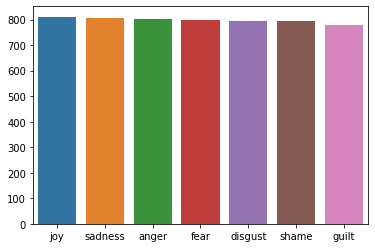

In [5]:
dd = pd.Series(y_train).value_counts()

# dd
sns.barplot(x=np.array(['joy','sadness','anger','fear','disgust','shame','guilt']),y=dd.values)
plt.show()

In [6]:
# dd

In [7]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

In [8]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
            
    print(type(y_train))
            
#     encoded_train = [1 if label =='positive' else 0 for label in y_train]  
#     encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    
    
    
#     #NAME_CONTRACT_TYPE ->catagorical to numerical

    emotion = {        
        'joy':1,
        'sadness':2,
        'anger':3,
        'fear': 4,
        'shame':5,
        'disgust':6,
        'guilt':0
    }
    encoded_train = [emotion[label] for label in y_train]


    encoded_test = [emotion[label] for label in y_val]


    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [9]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

<class 'numpy.ndarray'>


In [10]:
y_test

array([5, 3, 2, ..., 0, 0, 2])

In [11]:
y_train

array([5, 3, 0, ..., 3, 4, 6])

In [12]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


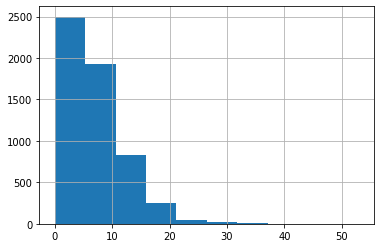

count    5584.000000
mean        7.213467
std         4.839897
min         0.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        53.000000
dtype: float64

In [13]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [14]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [15]:

x_train_pad = padding_(x_train, 9)
x_test_pad = padding_(x_test,9)

In [16]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 150

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [17]:
train_data[100]

(tensor([ 96, 258,   1,  25, 120, 212, 193, 657, 682], dtype=torch.int32),
 tensor(0, dtype=torch.int32))

In [18]:
y_train.shape

(5584,)

In [19]:
pd.Series(y_train).value_counts()

1    811
2    806
3    802
4    797
6    794
5    794
0    780
dtype: int64

In [20]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([150, 9])
Sample input: 
 tensor([[  0,   0, 143,  ..., 838, 351,  86],
        [  0,   0,   0,  ..., 278, 211, 193],
        [  0,   0,   0,  ..., 466,  36, 973],
        ...,
        [  0,   0,   0,  ..., 403,  63, 227],
        [  0,   0,   0,  ...,  73,  23, 130],
        [  0,   0,   0,  ...,   0,   0,   6]], dtype=torch.int32)
Sample input: 
 tensor([4, 6, 1, 4, 5, 6, 2, 4, 4, 0, 3, 0, 3, 0, 4, 1, 3, 6, 2, 3, 6, 0, 3, 2,
        0, 5, 5, 1, 5, 4, 1, 2, 4, 0, 4, 6, 4, 2, 3, 4, 3, 1, 3, 4, 5, 1, 5, 2,
        4, 4, 6, 6, 1, 6, 2, 6, 2, 2, 3, 2, 5, 3, 2, 4, 2, 0, 3, 4, 1, 1, 4, 5,
        0, 5, 4, 0, 4, 1, 1, 6, 1, 1, 3, 6, 6, 3, 3, 3, 0, 1, 4, 5, 0, 4, 3, 4,
        3, 6, 4, 5, 5, 3, 4, 4, 4, 2, 5, 2, 4, 2, 0, 5, 1, 4, 1, 1, 2, 3, 6, 2,
        4, 5, 3, 0, 6, 2, 4, 5, 2, 6, 1, 3, 2, 6, 6, 6, 5, 4, 2, 3, 1, 5, 2, 5,
        0, 2, 5, 3, 5, 3], dtype=torch.int32)


In [21]:
class SentimentLSTM(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentLSTM,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [22]:
# vocab

In [23]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 7
hidden_dim = 256

model = SentimentLSTM(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=7, bias=True)
  (sig): Sigmoid()
)


In [24]:
# loss and optimization functions
lr=0.001

# criterion = nn.BCELoss()

criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [25]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
#         print(epoch)
        
        inputs, labels = inputs.to(device), labels.to(device)   
        
#         print(inputs)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
#         print(h)
#         print(h[0])
        model.zero_grad()
        output,h = model(inputs,h)
        
        print(output.size() , len(h))
        
#         print(labels)
    
        loss = criterion(output, labels.float())
        loss.backward()
        train_losses.append(loss.item())
        
#         print(loss)
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
    print("pint 2")  
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            
            print(outputsqueeze() , labels.float())
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
#             print(labels)
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

torch.Size([150]) 2


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)